<a href="https://colab.research.google.com/github/GermanM3/GermanM3/blob/master/MSCI_%ED%8E%B8%EC%B6%9C_%EC%A2%85%EB%AA%A9_%EC%A0%84%EB%9E%B5(%EC%B5%9C%EC%A2%85).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install pykrx finance-datareader pandas_market_calendars


In [12]:
from google.colab import files
uploaded = files.upload()

Saving Data.xlsx to Data.xlsx


In [13]:
import pandas as pd
import FinanceDataReader as fdr
import pandas_market_calendars as mcal
from pandas.tseries.offsets import MonthEnd, BDay
from datetime import timedelta
df = pd.read_excel("Data.xlsx")  # 업로드된 파일명 그대로
df["Code"] = df["Code"].astype(str).str.zfill(6)

In [28]:
# Year, Month를 바탕으로 월의 마지막 영업일을 계산합니다.
df["Date"] = pd.to_datetime(df[["Year", "Month"]].assign(DAY=1)) + MonthEnd(0)
df["Date"] = df["Date"].apply(lambda x: x if x.weekday() < 5 else x - BDay(1))

# 월의 둘째 주 수요일을 계산하는 함수
def get_second_wednesday(date):
    first_day = pd.Timestamp(year=date.year, month=date.month, day=1)
    first_wed = first_day + timedelta(days=(2 - first_day.weekday()) % 7)
    second_wed = first_wed + timedelta(days=7)
    return second_wed

# 이벤트 날짜를 정의합니다.
df['Announcement Date'] = df['Date'].apply(get_second_wednesday)
df['Rebalancing'] = df['Date']

# 한국 증시 영업일 정보를 가져옵니다.
krx = mcal.get_calendar('XKRX')
schedule = krx.schedule(start_date='2015-01-01', end_date='2025-12-31')
krx_business_days = schedule.index

# 날짜를 가장 가까운 영업일로 보정하는 함수
def to_nearest_krx_bizday(date):
    try:
        return krx_business_days[krx_business_days <= pd.Timestamp(date)][-1]
    except:
        return pd.NaT

# 영업일 기준으로 날짜를 이동시키는 함수
def shift_krx_bizday(date, n):
    try:
        idx = krx_business_days.get_indexer([pd.Timestamp(date)], method='pad')[0]
        target_idx = idx + n
        if 0 <= target_idx < len(krx_business_days):
            return krx_business_days[target_idx]
        else:
            return pd.NaT
    except:
        return pd.NaT

# 날짜 보정을 적용합니다.
df["Announcement Date"] = df["Announcement Date"].apply(to_nearest_krx_bizday)
df["Rebalancing"] = df["Rebalancing"].apply(to_nearest_krx_bizday)

# 분석에 필요한 영업일 기준 ±일자를 계산합니다.
biz_offsets = {
    "Announcement_-60": ("Announcement Date", -60),
    "Announcement_-30": ("Announcement Date", -30),
    "Announcement_-21": ("Announcement Date", -21),
    "Announcement_-10": ("Announcement Date", -10),
    "Announcement_0":   ("Announcement Date", 0),
    "Rebalancing_0":     ("Rebalancing", 0),
    "Rebalancing_+10": ("Rebalancing", +10),
    "Rebalancing_+21": ("Rebalancing", +21),
    "Rebalancing_+63": ("Rebalancing", +63),
    "Rebalancing_+126": ("Rebalancing", +126),
    "Rebalancing_+252": ("Rebalancing", +252)
}

for col_name, (ref_col, offset) in biz_offsets.items():
    df[col_name] = df[ref_col].apply(lambda x: shift_krx_bizday(x, offset))

# 종가 데이터 조회를 위해 전체 기간을 설정하고 캐싱합니다.
all_dates = list(biz_offsets.keys())
min_date = df[all_dates].min().min()
max_date = df[all_dates].max().max()

price_dict = {}
for code in df["Code"].unique():
    try:
        price_df = fdr.DataReader(code, min_date, max_date)[["Close"]]
        price_dict[code] = price_df
    except Exception as e:
        print(f"{code} 오류: {e}")

# 종가 데이터를 가져오는 함수
def get_nearest_price(code, target_date):
    price_df = price_dict.get(code)
    if price_df is None or pd.isna(target_date):
        return None
    filtered = price_df.loc[:target_date]
    if filtered.empty:
        return None
    return filtered.iloc[-1]["Close"]

# 리밸런싱일 기준 종가와 수익률을 계산합니다.
df["Rebalancing_Price"] = df.apply(lambda row: get_nearest_price(row["Code"], row["Rebalancing_0"]), axis=1)

# **수정된 부분: Rebalancing 이후 수익률을 정방향으로 재계산**
for label in biz_offsets.keys():
    price_col = f"price_{label}"
    ret_col = f"ret_{label}"

    df[price_col] = df.apply(lambda row: get_nearest_price(row["Code"], row[label]), axis=1)

    # 'Rebalancing' 이후 시점에 대해서는 정방향 수익률 계산
    if 'Rebalancing_+' in label or label == 'Rebalancing_0':
        df[ret_col] = (df[price_col] / df["Rebalancing_Price"] - 1) * 100
    # 그 외 시점(발표일 전)에 대해서는 기존 수익률 계산 (역방향)
    else:
        df[ret_col] = (df["Rebalancing_Price"] / df[price_col] - 1) * 100

# 최종 데이터프레임을 정리하고 출력합니다.
result_cols = ["Code", "Name", "Announcement Date", "Rebalancing", "Rebalancing_Price"] + [f"ret_{k}" for k in biz_offsets]
print(df[result_cols].round(2))

# 편입/편출 종목의 평균 수익률을 계산합니다.
ret_cols = [col for col in df.columns if col.startswith('ret_')]
avg_ret_in = df[df['구분'] == '편입'][ret_cols].mean()
avg_ret_out = df[df['구분'] == '편출'][ret_cols].mean()

# 수정된 부분: 이벤트 타입 열 추가
result = pd.DataFrame({
    'relative_day_str': [col.replace('ret_', '') for col in ret_cols],
    'avg_ret_in': avg_ret_in.values,
    'avg_ret_out': avg_ret_out.values
})

# 이벤트 타입과 일자를 분리
result['event_type'] = result['relative_day_str'].apply(lambda x: x.split('_')[0])
result['relative_day'] = result['relative_day_str'].str.extract(r'([-+]?\d+)').astype(int)

# 정렬
result = result.sort_values(by=['event_type', 'relative_day']).reset_index(drop=True)

print("\n\n최종 분석 결과(평균 수익률):")
print(result)

/usr/local/lib/python3.12/dist-packages/pandas_market_calendars/market_calendar.py:178: UserWarning: ['break_start', 'break_end'] are discontinued, the dictionary `.discontinued_market_times` has the dates on which these were discontinued. The times as of those dates are incorrect, use .remove_time(market_time) to ignore a market_time.
  warnings.warn(


       Code       Name Announcement Date Rebalancing  Rebalancing_Price  \
0    009240         한샘        2015-02-11  2015-02-27           176500.0   
1    028050      삼성E&A        2015-02-11  2015-02-27            26182.0   
2    128940       한미약품        2015-05-13  2015-05-29           331728.0   
3    090435    아모레퍼시픽우        2015-05-13  2015-05-29           215500.0   
4    000080      하이트진로        2015-05-13  2015-05-29            21400.0   
..      ...        ...               ...         ...                ...   
162  302440  SK바이오사이언스        2025-02-12  2025-02-28            42550.0   
163  003230       삼양식품        2025-05-14  2025-05-30          1111000.0   
164  272210      한화시스템        2025-05-14  2025-05-30            45400.0   
165  450080     에코프로머티        2025-05-14  2025-05-30            45100.0   
166  036570      엔씨소프트        2025-05-14  2025-05-30           152500.0   

     ret_Announcement_-60  ret_Announcement_-30  ret_Announcement_-21  \
0                     NaN 

In [29]:
df.to_excel("MSCI-1.xlsx", index=False)

In [30]:
result

,relative_day_str,avg_ret_in,avg_ret_out,event_type,relative_day
0,Announcement_-60,59.068320,-15.959350,Announcement,-60
1,Announcement_-30,27.403173,-6.603373,Announcement,-30
2,Announcement_-21,16.220403,-4.235224,Announcement,-21
3,Announcement_-10,10.713836,-1.878901,Announcement,-10
4,Announcement_0,5.694547,-1.631112,Announcement,0
5,Rebalancing_0,0.000000,0.000000,Rebalancing,0
6,Rebalancing_+10,-0.076983,0.300661,Rebalancing,10
7,Rebalancing_+21,0.838752,-2.207258,Rebalancing,21
8,Rebalancing_+63,0.694814,2.416783,Rebalancing,63
9,Rebalancing_+126,0.946717,9.955053,Rebalancing,126


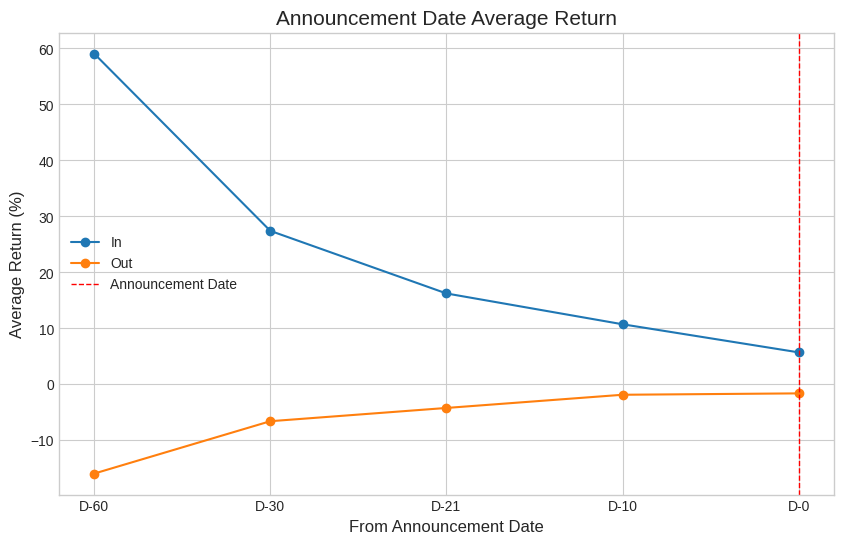

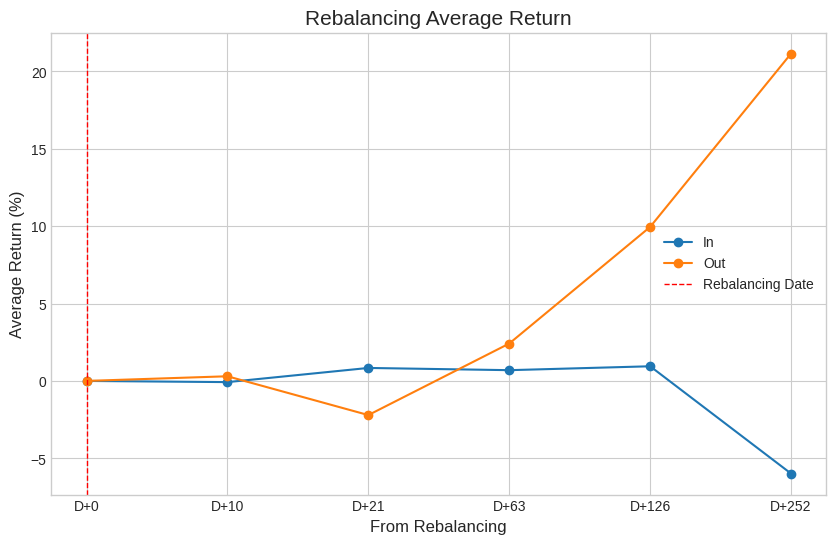

In [31]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 발표일 관련 데이터 필터링
announcement_data = result[result['event_type'] == 'Announcement'].copy()
announcement_labels = {
    -60: 'D-60', -30: 'D-30', -21: 'D-21', -10: 'D-10', 0: 'D-0'
}
announcement_data['day_label'] = announcement_data['relative_day'].map(announcement_labels)

# 편입일 관련 데이터 필터링
rebalancing_data = result[result['event_type'] == 'Rebalancing'].copy()
rebalancing_labels = {
    0: 'D+0', 10: 'D+10', 21: 'D+21', 63: 'D+63', 126: 'D+126', 252: 'D+252'
}
rebalancing_data['day_label'] = rebalancing_data['relative_day'].map(rebalancing_labels)


# 그래프 1: 발표일 전후 평균 수익률
plt.figure(figsize=(10, 6))
plt.plot(announcement_data['day_label'], announcement_data['avg_ret_in'], marker='o', label='In')
plt.plot(announcement_data['day_label'], announcement_data['avg_ret_out'], marker='o', label='Out')
plt.title('Announcement Date Average Return', fontsize=15)
plt.xlabel('From Announcement Date', fontsize=12)
plt.ylabel('Average Return (%)', fontsize=12)
plt.axvline(x='D-0', color='r', linestyle='--', linewidth=1, label='Announcement Date')
plt.legend()
plt.grid(True)
plt.show()

# 그래프 2: 편입일 전후 평균 수익률
plt.figure(figsize=(10, 6))
plt.plot(rebalancing_data['day_label'], rebalancing_data['avg_ret_in'], marker='o', label='In')
plt.plot(rebalancing_data['day_label'], rebalancing_data['avg_ret_out'], marker='o', label='Out')
plt.title('Rebalancing Average Return', fontsize=15)
plt.xlabel('From Rebalancing', fontsize=12)
plt.ylabel('Average Return (%)', fontsize=12)
plt.axvline(x='D+0', color='r', linestyle='--', linewidth=1, label='Rebalancing Date')
plt.legend()
plt.grid(True)
plt.show()